In [84]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Concatenate, Embedding, Attention
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Flatten
# --------------------------------
# 1. Load Data (Uploaded Structure)
# --------------------------------
df = pd.read_csv('merged_data.csv')

unique_districts = sorted(df['dist_code'].unique())
district2idx = {d: i for i, d in enumerate(unique_districts)}
df['district_idx'] = df['dist_code'].map(district2idx)
name2code = df.drop_duplicates('dist_name').set_index('dist_name')['dist_code'].to_dict()
# --------------------------------
# 2. Detect All Crop Yield Columns
# --------------------------------
# Detect columns ending with '_yield_(kg_per_ha)'
yield_cols = [col for col in df.columns if col.endswith('_yield_(kg_per_ha)')]

# For reporting
crop_names = [col.replace('_yield_(kg_per_ha)', '').replace('_', ' ').title() for col in yield_cols]

# --------------------------------
# 3. Temporal Feature Engineering
# --------------------------------
rain_cols = [
    'january_rainfall_millimeters', 'february_rainfall_millimeters', 'march_rainfall_millimeters',
    'april_rainfall_millimeters', 'may_rainfall_millimeters', 'june_rainfall_millimeters',
    'july_rainfall_millimeters', 'august_rainfall_millimeters', 'september_rainfall_millimeters',
    'october_rainfall_millimeters', 'november_rainfall_millimeters', 'december_rainfall_millimeters'
]

def engineer_features(group):
    # Rolling climate metrics (5-year window)
    group['5yr_rain_avg'] = group[rain_cols].sum(axis=1).rolling(5, min_periods=1).mean()
    # Drought indicators (consecutive dry months, example threshold: <50mm)
    group['Dry_Months'] = (group[rain_cols] < 50).sum(axis=1)
    # Anomaly detection: z-score vs 30-year baseline for monsoon months
    for m in ['june_rainfall_millimeters', 'july_rainfall_millimeters', 'august_rainfall_millimeters']:
        group[f'{m}_anomaly'] = (
            (group[m] - group[m].rolling(30, min_periods=1).mean()) /
            group[m].rolling(30, min_periods=1).std()
        )
    return group

df = df.groupby('dist_code').apply(engineer_features)

# --------------------------------
# 4. Data Splitting (Temporal-Spatial)
# --------------------------------
train = df[df.year <= 2000]
val = df[(df.year > 2000) & (df.year <= 2010)]
test = df[df.year > 2010]

# --------------------------------
# 5. Hybrid Model Architecture
# --------------------------------
def build_model(n_districts, seq_length=12, n_crops=1):
    seq_input = Input(shape=(seq_length, 1), name='rainfall_sequence')
    static_input = Input(shape=(1,), name='district_id')
    embed = Embedding(n_districts, 8)(static_input)
    embed = Flatten()(embed)
    embed = Dense(16, activation='relu')(embed)
    x = Bidirectional(LSTM(64, return_sequences=True))(seq_input)
    x = Attention()([x, x])
    x = Bidirectional(LSTM(32))(x)
    merged = Concatenate()([x, embed])
    outputs = []
    for i in range(n_crops):
        branch = Dense(32, activation='relu')(merged)
        branch = Dense(16, activation='relu')(branch)
        outputs.append(Dense(1, name=f'crop_{i}')(branch))
    model = Model(inputs=[seq_input, static_input], outputs=outputs)
    model.compile(optimizer='adam', loss='huber', metrics=['mae'] * len(yield_cols))
    return model


# --------------------------------
# 6. Training Pipeline
# --------------------------------
scaler_rain = StandardScaler().fit(train[rain_cols])
scaler_yield = StandardScaler().fit(train[yield_cols])


def create_sequences(data):
    return {
        'rainfall_sequence': scaler_rain.transform(data[rain_cols]).reshape(-1, 12, 1),
        'district_id': data['district_idx'].values,  # Use mapped index
        'targets': scaler_yield.transform(data[yield_cols])
    }

train_data = create_sequences(train)
val_data = create_sequences(val)
test_data = create_sequences(test)

model = build_model(
    n_districts=len(unique_districts),  # Use number of unique indices
    seq_length=12,
    n_crops=len(yield_cols)
)

history = model.fit(
    [train_data['rainfall_sequence'], train_data['district_id']],
    [train_data['targets'][:, i] for i in range(len(yield_cols))],
    validation_data=(
        [val_data['rainfall_sequence'], val_data['district_id']],
        [val_data['targets'][:, i] for i in range(len(yield_cols))]
    ),
    epochs=100,
    batch_size=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# --------------------------------
# 7. Evaluation & Interpretation
# --------------------------------
y_pred = model.predict([test_data['rainfall_sequence'], test_data['district_id']])
y_pred_actual = scaler_yield.inverse_transform(np.column_stack(y_pred))
y_test_actual = scaler_yield.inverse_transform(test_data['targets'])

for i, crop in enumerate(crop_names):
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred_actual[:, i]))
    print(f"{crop} RMSE: {rmse:.2f} kg/ha")

<ipython-input-84-200efb634a89>:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('dist_code').apply(engineer_features)


Epoch 1/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 27s 51ms/step - crop_0_loss: 0.3952 - crop_0_mae: 0.7632 - crop_1_loss: 0.3752 - crop_1_mae: 0.7441 - crop_2_loss: 0.3873 - crop_2_mae: 0.7460 - crop_3_loss: 0.3553 - crop_3_mae: 0.7105 - crop_4_loss: 0.3527 - crop_4_mae: 0.6778 - crop_5_loss: 0.2686 - crop_5_mae: 0.6025 - crop_6_loss: 0.4003 - crop_6_mae: 0.7745 - crop_7_loss: 0.3235 - crop_7_mae: 0.6841 - loss: 2.8581 - val_crop_0_loss: 0.4374 - val_crop_0_mae: 0.8037 - val_crop_1_loss: 0.4332 - val_crop_1_mae: 0.8097 - val_crop_2_loss: 0.5748 - val_crop_2_mae: 0.9705 - val_crop_3_loss: 0.8067 - val_crop_3_mae: 1.1537 - val_crop_4_loss: 0.6426 - val_crop_4_mae: 0.9510 - val_crop_5_loss: 0.5422 - val_crop_5_mae: 0.9215 - val_crop_6_loss: 0.2318 - val_crop_6_mae: 0.5308 - val_crop_7_loss: 0.4399 - val_crop_7_mae: 0.7750 - val_loss: 4.1211
Epoch 2/100
158/158 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - crop_0_loss: 0.2270 - crop_0_mae: 0.5381 - crop_1_loss: 0.2310 - crop_1_mae: 0.5516 - crop_2_loss: 0.31

In [85]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(district_name, crop_name):
    # Get district code from name
    if district_name not in name2code:
        print(f"District name '{district_name}' not found. Available names: {list(name2code.keys())[:5]} ...")
        return
    district_code = name2code[district_name]

    # Get district index
    if district_code not in district2idx:
        print(f"District code {district_code} for '{district_name}' not found in index mapping.")
        return
    district_idx = district2idx[district_code]

    # Check crop name validity
    crop_name_title = crop_name.title()
    if crop_name_title not in crop_names:
        print(f"Crop name '{crop_name}' not found. Available crops: {crop_names}")
        return
    crop_idx = crop_names.index(crop_name_title)

    # Filter test data for the district
    district_mask = (test['district_idx'] == district_idx)
    test_district = test[district_mask].copy()

    if test_district.empty:
        print(f"No test data available for district '{district_name}'.")
        return

    # Sort by year for proper plotting
    test_district = test_district.sort_values('year')

    # Prepare inputs for prediction
    X_rain = scaler_rain.transform(test_district[rain_cols]).reshape(-1, 12, 1)
    X_district = test_district['district_idx'].values

    # Predict
    y_pred = model.predict([X_rain, X_district])
    y_pred_actual = scaler_yield.inverse_transform(np.column_stack(y_pred))

    # Actual yields
    y_actual = test_district[yield_cols].values

    # Years for x-axis
    years = test_district['year'].values

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(years, y_actual[:, crop_idx], label='Actual', marker='o')
    plt.plot(years, y_pred_actual[:, crop_idx], label='Predicted', marker='x')
    plt.title(f"Actual vs Predicted Yield for {crop_name_title} in {district_name}")
    plt.xlabel('Year')
    plt.ylabel('Yield (kg/ha)')
    plt.legend()
    plt.grid(True)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


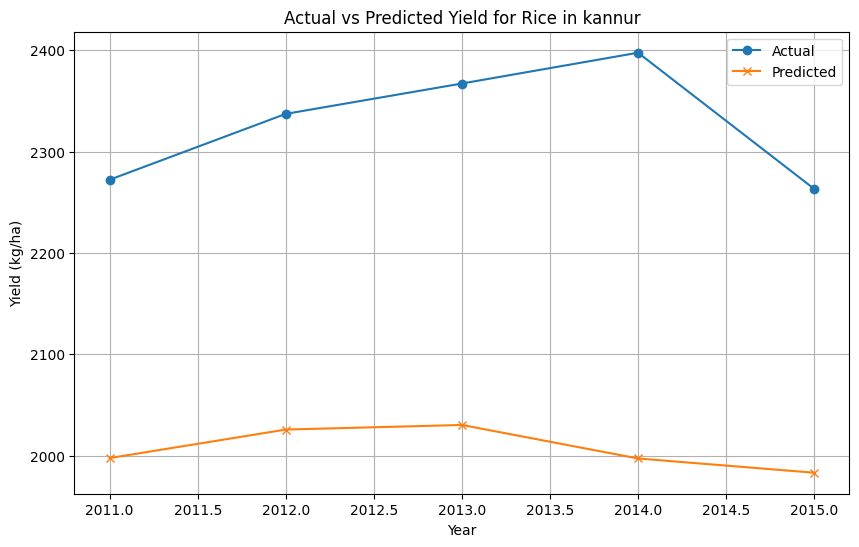

In [86]:
plot_actual_vs_predicted('kannur', 'rice')


In [87]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1. Load data
df = pd.read_csv('merged_data.csv')

# 2. Identify yield columns (all crops)
yield_cols = [col for col in df.columns if col.endswith('_yield_(kg_per_ha)')]
rain_cols = [
    'january_rainfall_millimeters', 'february_rainfall_millimeters', 'march_rainfall_millimeters',
    'april_rainfall_millimeters', 'may_rainfall_millimeters', 'june_rainfall_millimeters',
    'july_rainfall_millimeters', 'august_rainfall_millimeters', 'september_rainfall_millimeters',
    'october_rainfall_millimeters', 'november_rainfall_millimeters', 'december_rainfall_millimeters'
]

# 3. Map dist_code to contiguous indices for categorical encoding
df['district_idx'] = pd.factorize(df['dist_code'])[0]
name2idx = df.drop_duplicates('dist_name').set_index('dist_name')['district_idx'].to_dict()
crop_names = [col.replace('_yield_(kg_per_ha)', '').replace('_', ' ').title() for col in yield_cols]

# 4. Feature matrix: rainfall + district index
feature_cols = rain_cols + ['district_idx']

# 5. Remove rows with missing/invalid yield data (e.g., -1.0)
for col in yield_cols:
    df = df[df[col] >= 0]

# 6. Split data by year
train = df[df.year <= 2000]
val = df[(df.year > 2000) & (df.year <= 2010)]
test = df[df.year > 2010]

# 7. Prepare features and targets
X_train = train[feature_cols].values
X_val = val[feature_cols].values
X_test = test[feature_cols].values
Y_train = train[yield_cols].values
Y_val = val[yield_cols].values
Y_test = test[yield_cols].values

# 8. Feature scaling (important for tree-based models if features have very different scales)
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# 9. Train multi-output Random Forest
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
rf.fit(X_train_scaled, Y_train)

# 10. Predict and evaluate
Y_pred = rf.predict(X_test_scaled)

# 11. Report RMSE for each crop
for i, col in enumerate(yield_cols):
    rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred[:, i]))
    print(f"{col.replace('_yield_(kg_per_ha)','').replace('_',' ').title()} RMSE: {rmse:.2f} kg/ha")


Rice RMSE: 992.86 kg/ha
Wheat RMSE: 963.20 kg/ha
Groundnut RMSE: 852.85 kg/ha
Sunflower RMSE: 620.59 kg/ha
Soyabean RMSE: 581.31 kg/ha
Oilseeds RMSE: 1117.83 kg/ha
Sugarcane RMSE: 2901.54 kg/ha
Cotton RMSE: 189.83 kg/ha


In [88]:
import matplotlib.pyplot as plt

def plot_rf_actual_vs_predicted_by_name(district_name, crop_name):
    # Get district_idx from name
    if district_name not in name2idx:
        print(f"District name '{district_name}' not found. Available: {list(name2idx.keys())[:5]} ...")
        return
    district_idx = name2idx[district_name]

    # Check crop name validity
    crop_name_title = crop_name.title()
    if crop_name_title not in crop_names:
        print(f"Crop name '{crop_name}' not found. Available: {crop_names}")
        return
    crop_idx = crop_names.index(crop_name_title)

    # Filter test data for the district
    district_mask = (test['district_idx'] == district_idx)
    test_district = test[district_mask].copy()
    if test_district.empty:
        print(f"No test data for district '{district_name}'.")
        return

    # Sort by year for time-series plotting
    test_district = test_district.sort_values('year')

    # Prepare features for prediction
    X_test_district = test_district[feature_cols].values
    X_test_district_scaled = scaler_X.transform(X_test_district)

    # Predict
    Y_pred_district = rf.predict(X_test_district_scaled)

    # Actual yields
    Y_actual_district = test_district[yield_cols].values

    # Years for x-axis
    years = test_district['year'].values

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(years, Y_actual_district[:, crop_idx], label='Actual', marker='o')
    plt.plot(years, Y_pred_district[:, crop_idx], label='Predicted', marker='x')
    plt.title(f"Actual vs Predicted Yield for {crop_name_title} in {district_name} (Random Forest)")
    plt.xlabel('Year')
    plt.ylabel('Yield (kg/ha)')
    plt.legend()
    plt.grid(True)
    plt.show()


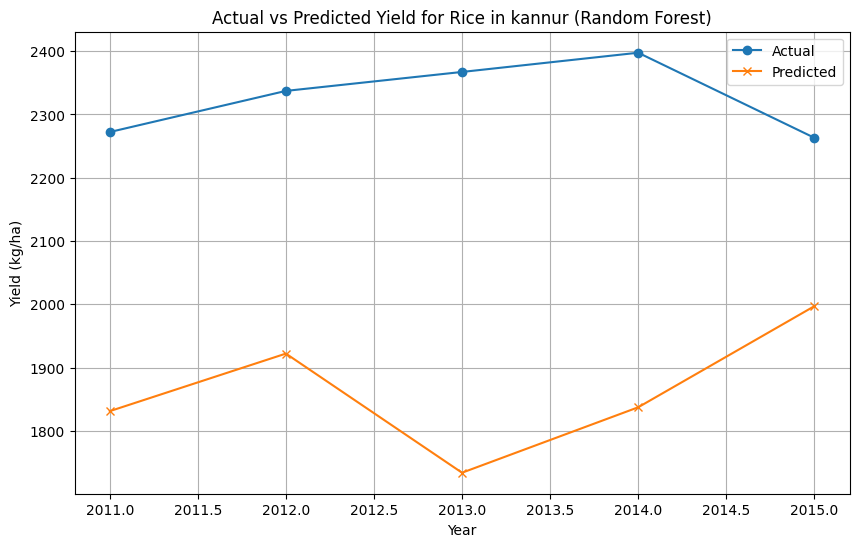

In [89]:
plot_rf_actual_vs_predicted_by_name('kannur', 'rice')


In [90]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 1. Load data
df = pd.read_csv('merged_data.csv')

# 2. Identify yield columns (all crops)
yield_cols = [col for col in df.columns if col.endswith('_yield_(kg_per_ha)')]
rain_cols = [
    'january_rainfall_millimeters', 'february_rainfall_millimeters', 'march_rainfall_millimeters',
    'april_rainfall_millimeters', 'may_rainfall_millimeters', 'june_rainfall_millimeters',
    'july_rainfall_millimeters', 'august_rainfall_millimeters', 'september_rainfall_millimeters',
    'october_rainfall_millimeters', 'november_rainfall_millimeters', 'december_rainfall_millimeters'
]

# 3. Map dist_code to contiguous indices for categorical encoding
df['district_idx'] = pd.factorize(df['dist_code'])[0]

# Mapping from district name to district_idx
name2idx = df.drop_duplicates('dist_name').set_index('dist_name')['district_idx'].to_dict()

# Human-friendly crop names
crop_names = [col.replace('_yield_(kg_per_ha)', '').replace('_', ' ').title() for col in yield_cols]

# 4. Feature matrix: rainfall + district index
feature_cols = rain_cols + ['district_idx']

# 5. Remove rows with missing/invalid yield data (e.g., -1.0)
for col in yield_cols:
    df = df[df[col] >= 0]

# 6. Split data by year
train = df[df.year <= 2000]
val = df[(df.year > 2000) & (df.year <= 2010)]
test = df[df.year > 2010]

# 7. Prepare features and targets
X_train = train[feature_cols].values
X_val = val[feature_cols].values
X_test = test[feature_cols].values
Y_train = train[yield_cols].values
Y_val = val[yield_cols].values
Y_test = test[yield_cols].values

# 8. Feature scaling (important for linear models)
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# 9. Multi-output Linear Regression
lr = MultiOutputRegressor(LinearRegression())
lr.fit(X_train_scaled, Y_train)
Y_pred_lr = lr.predict(X_test_scaled)

print("Multi-output Linear Regression RMSEs:")
for i, col in enumerate(yield_cols):
    rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred_lr[:, i]))
    print(f"{col.replace('_yield_(kg_per_ha)','').replace('_',' ').title()} RMSE: {rmse:.2f} kg/ha")

# 10. Multi-output Ridge Regression
ridge = MultiOutputRegressor(Ridge(alpha=1.0))
ridge.fit(X_train_scaled, Y_train)
Y_pred_ridge = ridge.predict(X_test_scaled)

print("\nMulti-output Ridge Regression RMSEs:")
for i, col in enumerate(yield_cols):
    rmse = np.sqrt(mean_squared_error(Y_test[:, i], Y_pred_ridge[:, i]))
    print(f"{col.replace('_yield_(kg_per_ha)','').replace('_',' ').title()} RMSE: {rmse:.2f} kg/ha")


Multi-output Linear Regression RMSEs:
Rice RMSE: 1282.54 kg/ha
Wheat RMSE: 1282.71 kg/ha
Groundnut RMSE: 917.41 kg/ha
Sunflower RMSE: 651.95 kg/ha
Soyabean RMSE: 615.57 kg/ha
Oilseeds RMSE: 1144.72 kg/ha
Sugarcane RMSE: 3505.31 kg/ha
Cotton RMSE: 224.05 kg/ha

Multi-output Ridge Regression RMSEs:
Rice RMSE: 1282.54 kg/ha
Wheat RMSE: 1282.72 kg/ha
Groundnut RMSE: 917.41 kg/ha
Sunflower RMSE: 651.95 kg/ha
Soyabean RMSE: 615.57 kg/ha
Oilseeds RMSE: 1144.72 kg/ha
Sugarcane RMSE: 3505.30 kg/ha
Cotton RMSE: 224.05 kg/ha


In [91]:
import matplotlib.pyplot as plt

def plot_linear_and_ridge_by_name(
    district_name, crop_name,
    lr_model, ridge_model,
    scaler_X, test_df,
    feature_cols, yield_cols, crop_names, name2idx
):
    # Get district_idx from name
    if district_name not in name2idx:
        print(f"District name '{district_name}' not found. Available: {list(name2idx.keys())[:5]} ...")
        return
    district_idx = name2idx[district_name]

    # Check crop name validity
    crop_name_title = crop_name.title()
    if crop_name_title not in crop_names:
        print(f"Crop name '{crop_name}' not found. Available: {crop_names}")
        return
    crop_idx = crop_names.index(crop_name_title)

    # Filter test data for the district
    district_mask = (test_df['district_idx'] == district_idx)
    test_district = test_df[district_mask].copy()
    if test_district.empty:
        print(f"No test data for district '{district_name}'.")
        return

    # Sort by year for time-series plotting
    test_district = test_district.sort_values('year')

    # Prepare features for prediction
    X_test_district = test_district[feature_cols].values
    X_test_district_scaled = scaler_X.transform(X_test_district)

    # Predict
    Y_pred_lr = lr_model.predict(X_test_district_scaled)
    Y_pred_ridge = ridge_model.predict(X_test_district_scaled)

    # Actual yields
    Y_actual_district = test_district[yield_cols].values

    # Years for x-axis
    years = test_district['year'].values

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(years, Y_actual_district[:, crop_idx], label='Actual', marker='o', color='black')
    plt.plot(years, Y_pred_lr[:, crop_idx], label='Linear Regression', marker='x', linestyle='--', color='blue')
    plt.plot(years, Y_pred_ridge[:, crop_idx], label='Ridge Regression', marker='s', linestyle='-.', color='red')
    plt.title(f"Actual vs Predicted Yield for {crop_name_title} in {district_name}\n(Linear & Ridge Regression)")
    plt.xlabel('Year')
    plt.ylabel('Yield (kg/ha)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


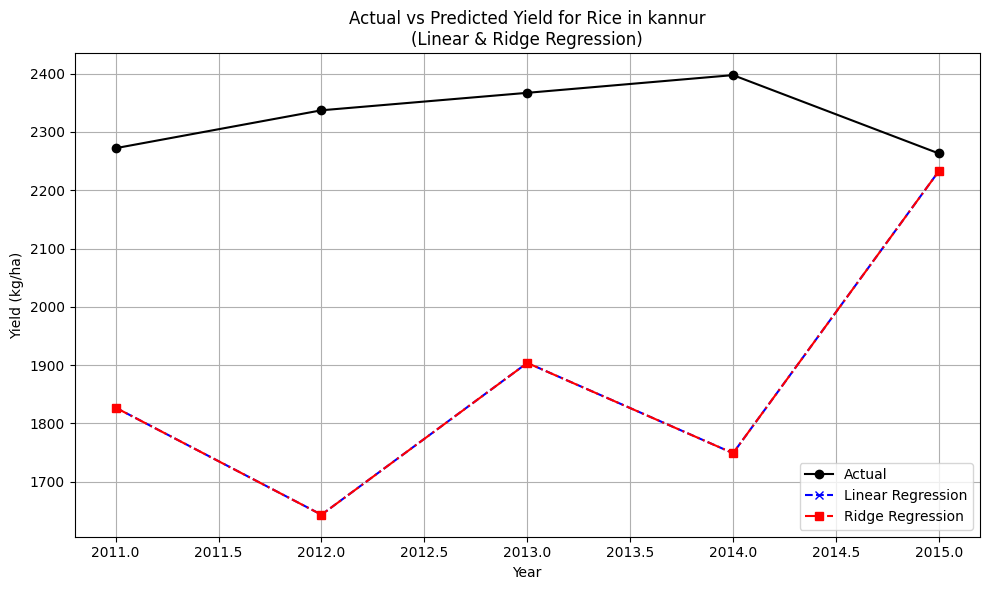

In [92]:
# Example usage:
plot_linear_and_ridge_by_name(
    'kannur', 'rice',
    lr, ridge,
    scaler_X, test,
    feature_cols, yield_cols, crop_names, name2idx
)


In [93]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- Load data ---
df = pd.read_csv("merged_data.csv")

rainfall_cols = [
    'january_rainfall_millimeters', 'february_rainfall_millimeters', 'march_rainfall_millimeters',
    'april_rainfall_millimeters', 'may_rainfall_millimeters', 'june_rainfall_millimeters',
    'july_rainfall_millimeters', 'august_rainfall_millimeters', 'september_rainfall_millimeters',
    'october_rainfall_millimeters', 'november_rainfall_millimeters', 'december_rainfall_millimeters'
]

# List all crop yield and production columns you want to model
crop_targets = [
    'rice_yield_(kg_per_ha)', 'wheat_yield_(kg_per_ha)', 'groundnut_yield_(kg_per_ha)',
    'sunflower_yield_(kg_per_ha)', 'soyabean_yield_(kg_per_ha)', 'oilseeds_yield_(kg_per_ha)',
    'sugarcane_yield_(kg_per_ha)', 'cotton_yield_(kg_per_ha)', 'potatoes_area_(1000_ha)', 'onion_area_(1000_ha)',
    'rice_production_(1000_tons)', 'wheat_production_(1000_tons)', 'groundnut_production_(1000_tons)',
    'sunflower_production_(1000_tons)', 'soyabean_production_(1000_tons)', 'oilseeds_production_(1000_tons)',
    'sugarcane_production_(1000_tons)', 'cotton_production_(1000_tons)'
]

# Remove invalid data
df = df.replace(-1.0, np.nan)
df = df.dropna(subset=['year', 'dist_name', 'annual_rainfall_millimeters'] + rainfall_cols)

features = ['year'] + rainfall_cols

# --- Train SVR models for all districts and all crops ---
model_dict = {}

for district in df['dist_name'].unique():
    district_df = df[df['dist_name'] == district].sort_values('year')
    for crop in crop_targets:
        if crop not in district_df.columns:
            continue
        # Remove rows with missing crop data
        sub_df = district_df.dropna(subset=[crop])
        if len(sub_df) < 10:
            continue
        # Prepare features and target
        X = sub_df[features].copy()
        X['year'] = X['year'] * 0.01  # Reduce year importance
        X = X.values
        y = sub_df[crop].values
        years = sub_df['year'].values
        annual_rainfall = sub_df['annual_rainfall_millimeters'].values

        # Time splits
        train_idx = years < 2000
        val_idx = (years >= 2000) & (years <= 2010)
        test_idx = years > 2010

        if np.sum(train_idx) < 5 or np.sum(val_idx) < 1 or np.sum(test_idx) < 1:
            continue

        # Standardize
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_train = scaler_X.fit_transform(X[train_idx])
        y_train = scaler_y.fit_transform(y[train_idx].reshape(-1, 1)).ravel()

        # Train SVR
        svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
        svr.fit(X_train, y_train)

        # Store model and scalers
        model_dict[(district, crop)] = {
            'model': svr,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'X': X,
            'y': y,
            'years': years,
            'annual_rainfall': annual_rainfall,
            'train_idx': train_idx,
            'val_idx': val_idx,
            'test_idx': test_idx
        }

def plot_svr_district_crop(district, crop):
    key = (district, crop)
    if key not in model_dict:
        print(f"No model found for district '{district}' and crop '{crop}'.")
        return
    entry = model_dict[key]
    svr = entry['model']
    scaler_X = entry['scaler_X']
    scaler_y = entry['scaler_y']
    X = entry['X']
    y = entry['y']
    years = entry['years']
    annual_rainfall = entry['annual_rainfall']
    train_idx = entry['train_idx']
    val_idx = entry['val_idx']
    test_idx = entry['test_idx']

    y_pred = scaler_y.inverse_transform(svr.predict(scaler_X.transform(X)).reshape(-1, 1)).ravel()

    # Metrics
    def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
    print(f"\nDistrict: {district} | Crop: {crop}")
    print(f"Train R2: {r2_score(y[train_idx], y_pred[train_idx]):.2f} | RMSE: {rmse(y[train_idx], y_pred[train_idx]):.2f}")
    print(f"Val   R2: {r2_score(y[val_idx], y_pred[val_idx]):.2f} | RMSE: {rmse(y[val_idx], y_pred[val_idx]):.2f}")
    print(f"Test  R2: {r2_score(y[test_idx], y_pred[test_idx]):.2f} | RMSE: {rmse(y[test_idx], y_pred[test_idx]):.2f}")

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(years, y, 'ko-', label='Actual')
    ax1.plot(years, y_pred, 'r--', label='SVR Prediction')
    ax1.set_xlabel("Year")
    ax1.set_ylabel(crop)
    ax1.legend(loc='upper left')

    # Rainfall on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(years, annual_rainfall, 'b.-', label='Annual Rainfall (mm)', alpha=0.5)
    ax2.set_ylabel('Annual Rainfall (mm)', color='b')
    ax2.tick_params(axis='y', labelcolor='b')

    plt.title(f"SVR for {district} - {crop}\n(Year scaled, Rainfall shown)")
    fig.tight_layout()
    plt.show()

crop_rmse = {}

for crop in crop_targets:
    y_tests = []
    y_preds = []
    for (district, crop_name), entry in model_dict.items():
        if crop_name != crop:
            continue
        y = entry['y']
        years = entry['years']
        test_idx = entry['test_idx']
        if np.sum(test_idx) == 0:
            continue
        svr = entry['model']
        scaler_X = entry['scaler_X']
        scaler_y = entry['scaler_y']
        X = entry['X']
        X_test = X[test_idx]
        y_test = y[test_idx]
        y_pred = scaler_y.inverse_transform(
            svr.predict(scaler_X.transform(X_test)).reshape(-1, 1)
        ).ravel()
        y_tests.append(y_test)
        y_preds.append(y_pred)
    if y_tests and y_preds:
        all_y_test = np.concatenate(y_tests)
        all_y_pred = np.concatenate(y_preds)
        rmse = np.sqrt(mean_squared_error(all_y_test, all_y_pred))
        crop_rmse[crop] = rmse

# Print RMSE for each crop
for crop, rmse in crop_rmse.items():
    print(f"{crop}: RMSE = {rmse:.2f}")


rice_yield_(kg_per_ha): RMSE = 873.61
wheat_yield_(kg_per_ha): RMSE = 887.39
groundnut_yield_(kg_per_ha): RMSE = 743.35
sunflower_yield_(kg_per_ha): RMSE = 599.20
soyabean_yield_(kg_per_ha): RMSE = 518.24
oilseeds_yield_(kg_per_ha): RMSE = 1108.80
sugarcane_yield_(kg_per_ha): RMSE = 2794.00
cotton_yield_(kg_per_ha): RMSE = 182.48
potatoes_area_(1000_ha): RMSE = 8.12
onion_area_(1000_ha): RMSE = 4.42
rice_production_(1000_tons): RMSE = 233.20
wheat_production_(1000_tons): RMSE = 274.07
groundnut_production_(1000_tons): RMSE = 65.77
sunflower_production_(1000_tons): RMSE = 5.62
soyabean_production_(1000_tons): RMSE = 76.26
oilseeds_production_(1000_tons): RMSE = 122.61
sugarcane_production_(1000_tons): RMSE = 183.57
cotton_production_(1000_tons): RMSE = 32.10



District: kannur | Crop: rice_yield_(kg_per_ha)
Train R2: 0.99 | RMSE: 7.28
Val   R2: -10.55 | RMSE: 331.72
Test  R2: -103.82 | RMSE: 537.26


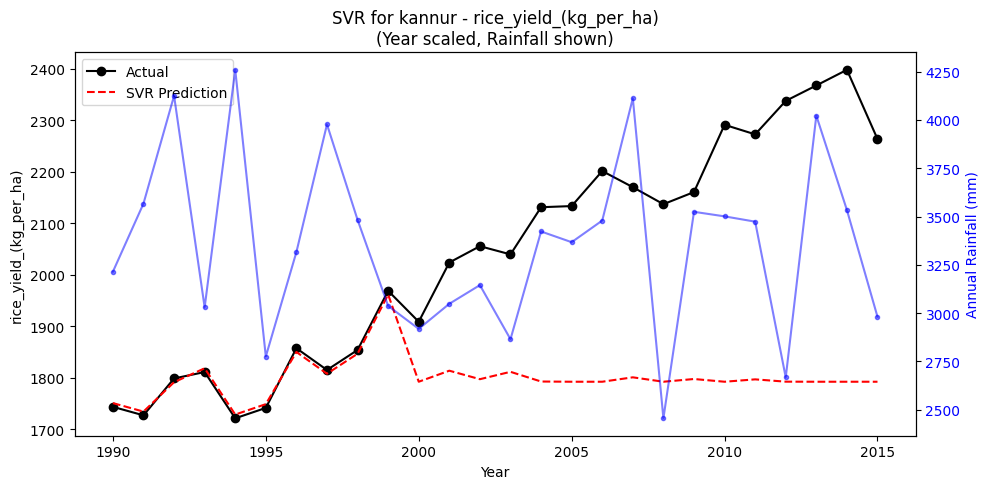


District: raipur | Crop: wheat_production_(1000_tons)
Train R2: 0.99 | RMSE: 0.57
Val   R2: -0.87 | RMSE: 2.91
Test  R2: -9.92 | RMSE: 5.91


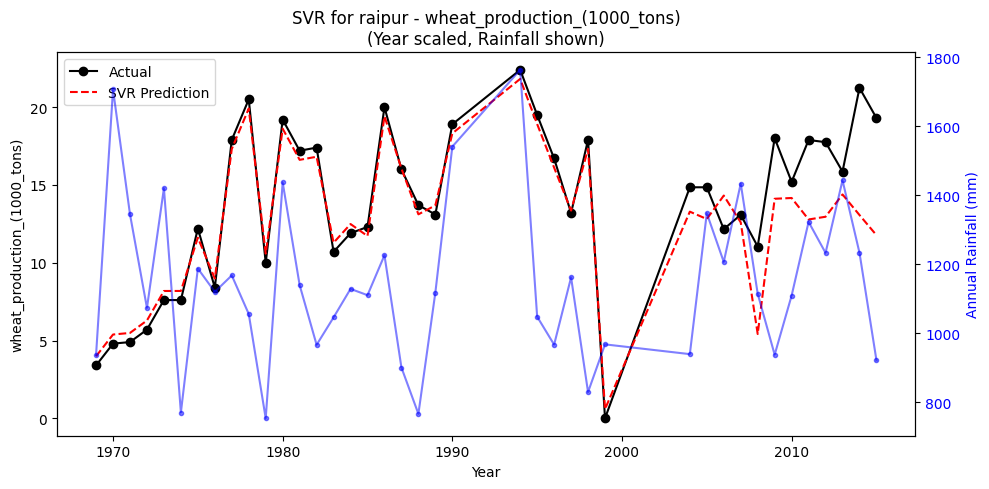

In [94]:
# Example usage:
plot_svr_district_crop('kannur', 'rice_yield_(kg_per_ha)')
plot_svr_district_crop('raipur', 'wheat_production_(1000_tons)')